In [1]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf
import epyestim.covid19 as c19
from epyestim.distributions import discretise_gamma
import multiprocessing as mp
import itertools

In [2]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

In [3]:
wide_data_total = pd.read_csv('Data/wide_total.csv')
wide_data_total['date'] = pd.to_datetime(wide_data_total['date'])
wide_data_total.set_index('date',inplace=True)
weekly_counts_total = pd.read_csv('Data/weekly_total.csv')
weekly_counts_total['date'] = pd.to_datetime(weekly_counts_total['date'])
weekly_counts_total.set_index('date',inplace=True)
cases = pd.read_csv('Data/cases_total.csv')
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date',inplace=True)
npis = pd.read_csv('Data/ltla_to_nhs.csv')

In [4]:
# Get signals short windows
ews_7total, norm_ews_7total = calculate_ews_rolling(wide_data_total,window_size=7)
ews_14total, norm_ews_14total = calculate_ews_rolling(wide_data_total,window_size=14)

In [5]:
def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, transition_dates, ltla):
    std_val = []
    mean_val = []
    prev_date = pd.Timestamp.min
    for date in transition_dates:
        current_timeseries = stat_timeseries[(stat_timeseries['date'] > prev_date) & (stat_timeseries['date'] <= date)]
        running_std, running_mean = long_run_averages(current_timeseries[ltla].values)
        std_val = np.concatenate((std_val,running_std))
        mean_val = np.concatenate((mean_val,running_mean))
        prev_date = date
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, ltlas, ltla_transitions):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for ltla in ltlas:
            transition_dates = ltla_transitions[ltla]
            stat_data = ews_dict[stat][ltla].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, transition_dates, ltla)
            indices_dict[stat][ltla] = indices
            mean_dict[stat][ltla] = mean_val
            std_dict[stat][ltla] = std_val
    return indices_dict, mean_dict, std_dict

In [6]:
import pickle        
with open('Data/ltla_transitions.pkl', 'rb') as f:
    ltla_transitions = pickle.load(f)

In [7]:
ews_dict = norm_ews_7total
ltlas = ['Amber Valley']
areas = ltlas
two_sigma_cutoff, mean_dict, std_dict = loop_EWSs_store_results_cutoffs(ews_dict, ltlas, ltla_transitions)

/tmp/ipykernel_8846/56531340.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_8846/56531340.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_8846/56531340.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=ou

In [8]:
# Get detect indices for timeline
from operator import itemgetter

def detect(arr):
    if len(arr) < 3:
        return []

    values = []
    i = 0
    # Find length 3 consecutive sequences
    while i < len(arr) - 2:
        if arr[i] + 1 == arr[i + 1] and arr[i + 1] + 1 == arr[i + 2]:
            values.append(arr[i + 2])
            while i + 2 < len(arr) - 1 and arr[i + 2] + 1 == arr[i + 3]:
                i += 1
        i += 1
    
    return values

In [9]:
detect_var = {}
detect_fd = {}

for area in areas:
    detect_var[area] = detect(two_sigma_cutoff['variance'][area])
    detect_fd[area] = detect(two_sigma_cutoff['first diff'][area])

In [25]:
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

/tmp/ipykernel_8846/955607501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['rolling'] = counts['value'].rolling(7).sum()


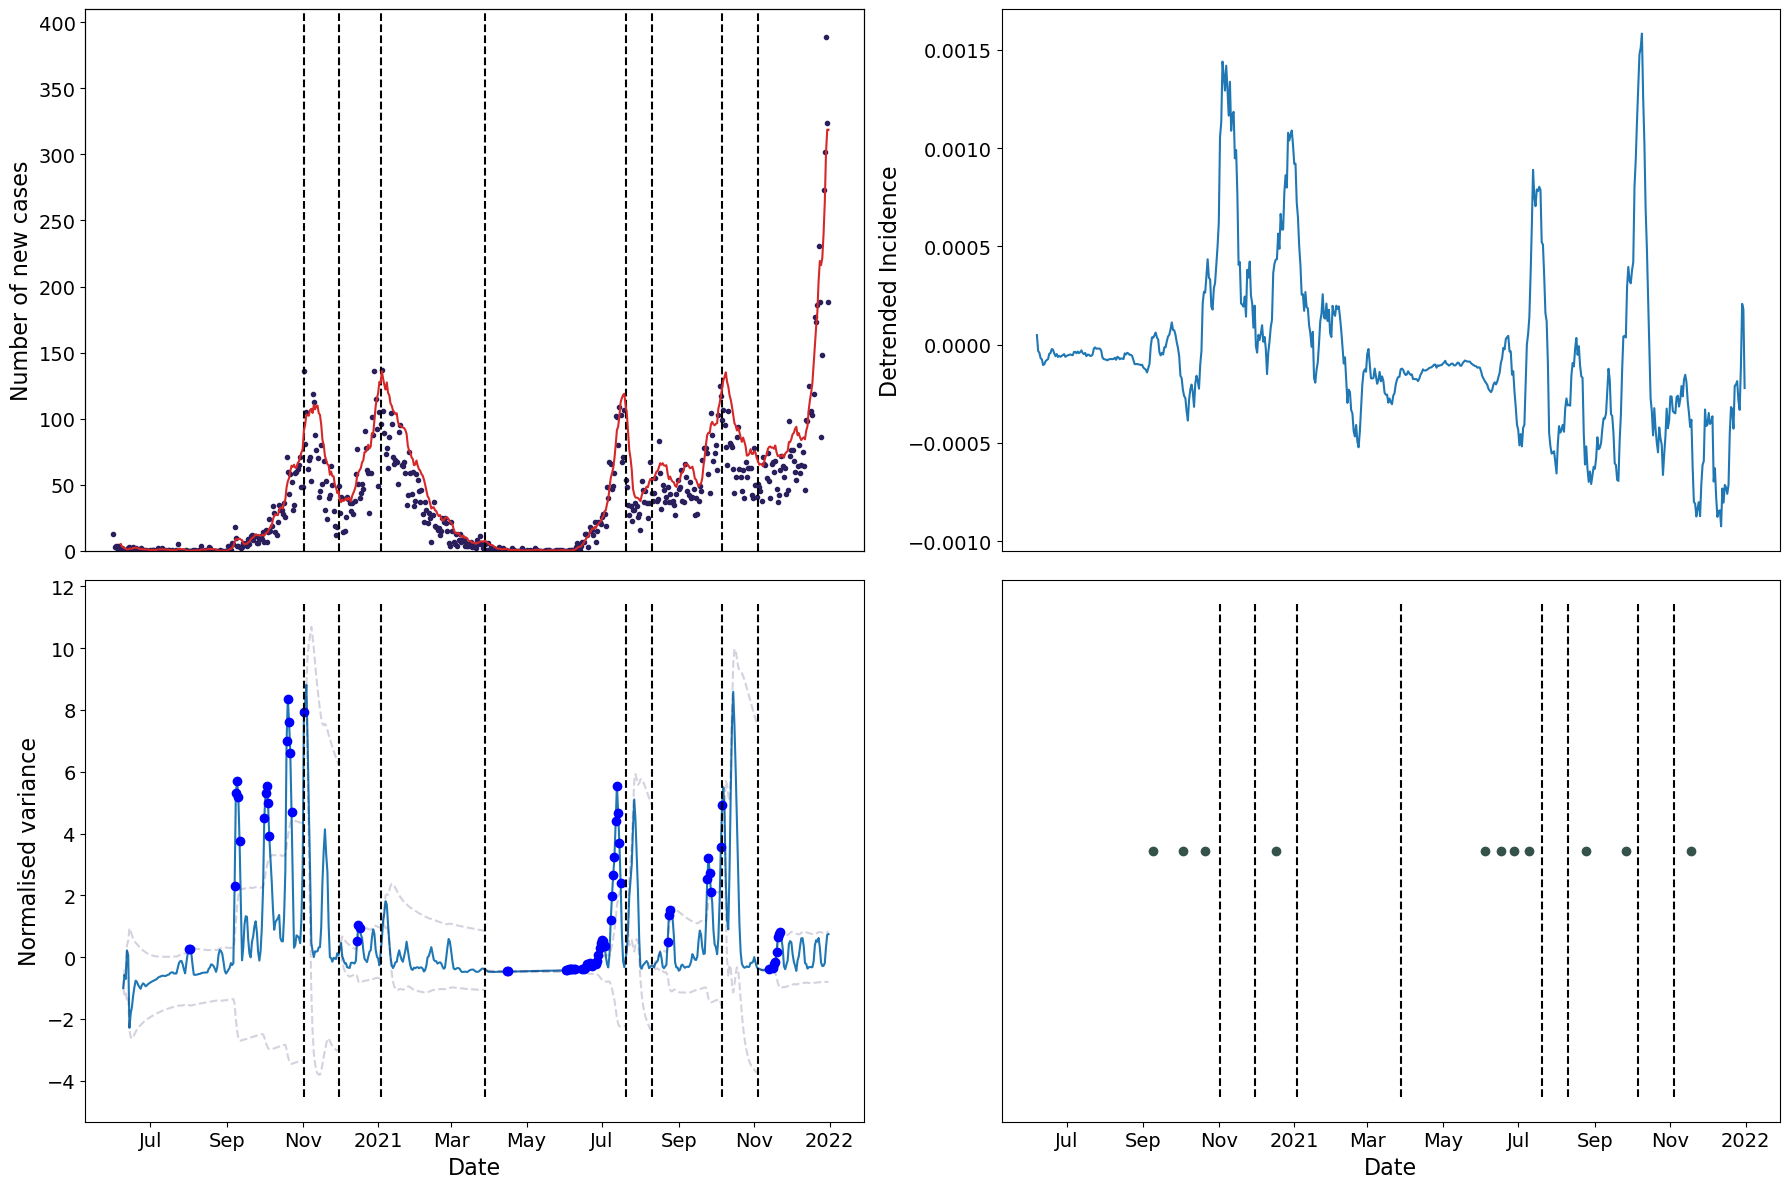

In [31]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(18,12))
stat = "variance"

counts = cases[cases['area_name']=='Amber Valley']
counts['rolling'] = counts['value'].rolling(7).sum()
counts = counts.reset_index()
axs[0,0].plot(counts['date'],counts['value'],'.',color='#2A1E5C')
axs[0,0].set_ylim((0,410))
axs[0,0].set_ylabel('Number of new cases',fontsize=16)
ax = axs[0,0].twinx()
axs[0,0].vlines(x=ltla_transitions['Amber Valley'][:-1],ymin=0,ymax=410,color='k',linestyle='--') 
ax.plot(counts['date'],counts['rolling'],color='#D62828')
ax.set_ylim((0,2200))
axs[0,1].plot(wide_data_total.reset_index()['date'],wide_data_total.reset_index()['Amber Valley'])
axs[0,1].set_ylabel('Detrended Incidence',fontsize=16)
stat_data = norm_ews_7total[stat]
y_data = stat_data['Amber Valley'].copy(deep=True)
std_val = std_dict[stat]['Amber Valley']
mean_val = mean_dict[stat]['Amber Valley']
axs[1,0].plot(y_data.reset_index()['date'],y_data.reset_index()['Amber Valley'])
y_data = y_data.reset_index()
y_data['Top'] = mean_val + 2*std_val
y_data['Bottom'] = mean_val - 2*std_val
axs[1,0].plot(y_data['date'],y_data['Top'],color='#2A1E5C',alpha=0.2,linestyle='--',label='Threshold')
axs[1,0].plot(y_data['date'],y_data['Bottom'],color='#2A1E5C',alpha=0.2,linestyle='--',label='')
y_data = y_data.iloc[two_sigma_cutoff[stat]['Amber Valley']].drop(columns=['Top','Bottom'])
axs[1,0].plot(y_data['date'],y_data['Amber Valley'],'o',color='blue',label='Exceeds threshold')
axs[1,0].set_ylabel('Normalised variance',fontsize=16)
axs[1,0].vlines(x=ltla_transitions['Amber Valley'][:-1],ymin=axs[1,0].get_ylim()[0],ymax=axs[1,0].get_ylim()[1],color='k',linestyle='--')
axs[1,0].set_ylim(axs[1,0].get_ylim())


axs[1,1].vlines(x=ltla_transitions['Amber Valley'][:-1],ymin=-1,ymax=1,color='k',label='Critical Transition',linestyle='--')    
signal_data = norm_ews_7total['variance']['Amber Valley']
signal_data = signal_data.reset_index()
xs = signal_data['date'][detect_var['Amber Valley']]
axs[1,1].plot(xs,[0]*len(xs),'o',color='#35524A',label='Variance')

for i in range(2):
    for j in range(2):
        if i == 0:
            axs[i,j].set_xticks(())
        else:
            axs[i,j].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)
        axs[i,j].set_xlim((18391.4, 19020.6))

ax.get_yaxis().set_ticks([]) 
axs[1,1].get_yaxis().set_ticks([])
axs[1,0].set_xlabel('Date',fontsize=16)
axs[1,1].set_xlabel('Date',fontsize=16)  
fig.tight_layout()
plt.savefig('Figures/methods.pdf')
plt.show()